# Explore here

It's recommended to use this notebook for exploration purposes.

For example: 

1. You could import the CSV generated by python into your notebook and explore it.
2. You could connect to your database using `pandas.read_sql` from this notebook and explore it.

In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install plotly
# %pip install sklearn
# %pip install statsmodels

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import plotly.graph_objects as go


In [7]:
#1. Load dataset
#df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv')
df_raw = pd.read_csv('../data/raw/medical_insurance_cost.csv')

In [8]:
#df_raw.to_csv('../data/raw/medical_insurance_cost.csv')

In [9]:
# 1.1 Get basic info
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
# 1.2 Take a sample
df_raw.sample(3)

,age,sex,bmi,children,smoker,region,charges
1184,23,female,28.490,1,yes,southeast,18328.23810
755,31,male,27.645,2,no,northeast,5031.26955
439,26,male,29.450,0,no,northeast,2897.32350


In [11]:
df_raw.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



Tenemos un total de 6 variables dependientes de las cuales tres son continuas y tres categoricas (region, sex, smoker)

In [12]:
# 1.3 Transform if needed

#A - Datos duplicados (hay una observacion duplicada)

df_transformed=df_raw.copy()

In [13]:
columns_names = df_transformed.columns.values
columns_names.tolist()

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [14]:
df_transformed.drop_duplicates(subset=columns_names.tolist(), keep='last').shape

(1337, 7)

In [15]:
# B - Datos NaN (no estan presentes en el dataframe)
df_transformed.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [16]:
# C - Transformacion de categoricas en variables dummies

# If a feature has n categoriess, it will be transformed into n-1 dummies
# For the sex feature, female will be the reference category
# For the smoker feature, non-smoker will be the reference category
# For the region feature, northeast will be the reference category

df_transformed = pd.get_dummies(df_raw, drop_first=True)
df_transformed.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [17]:
# Step 2. Make a basic EDA
df=df_transformed.copy()
X = df.drop(['charges'], axis=1)
y= df['charges']

In [18]:
# 2.1 Split the dataset so to avoid bias
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

In [19]:
# 2.2 Join the train sets to ease 
df_train=pd.concat([X_train, y_train], axis=1)

In [20]:
# 2.3 Get basic info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1003 entries, 826 to 645
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1003 non-null   int64  
 1   bmi               1003 non-null   float64
 2   children          1003 non-null   int64  
 3   sex_male          1003 non-null   uint8  
 4   smoker_yes        1003 non-null   uint8  
 5   region_northwest  1003 non-null   uint8  
 6   region_southeast  1003 non-null   uint8  
 7   region_southwest  1003 non-null   uint8  
 8   charges           1003 non-null   float64
dtypes: float64(2), int64(2), uint8(5)
memory usage: 44.1 KB


In [21]:
# 2.4 Take a sample
df_train.sample(10)

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,charges
593,21,21.850,1,0,1,0,0,0,15359.10450
167,32,33.155,3,0,0,1,0,0,6128.79745
1015,59,25.460,0,1,0,1,0,0,12124.99240
379,62,31.460,1,1,0,0,1,0,27000.98473
3,33,22.705,0,1,0,1,0,0,21984.47061
1039,19,27.265,2,1,0,1,0,0,22493.65964
306,28,27.500,2,0,0,0,0,1,20177.67113
216,53,26.600,0,0,0,1,0,0,10355.64100
278,59,31.790,2,1,0,0,1,0,12928.79110
816,24,24.225,0,0,0,1,0,0,2842.76075


In [22]:
# 2.5 Describe the numerical and date variables
df_train.describe()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,charges
count,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000
mean,39.430708,30.729467,1.091725,0.505484,0.199402,0.235294,0.262213,0.256231,13374.181392
std,14.111544,6.135503,1.219257,0.500219,0.399750,0.424394,0.440057,0.436769,12144.417938
min,18.000000,15.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,26.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4764.175500
50%,40.000000,30.400000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9566.990900
75%,52.000000,34.800000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,16909.822725
max,64.000000,53.130000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,63770.428010


In [23]:
# 2.8 Perform univariate analysis - boxplots
df_num = df_train.select_dtypes(np.number)
num = df_num.columns.values.tolist()
num

['age',
 'bmi',
 'children',
 'sex_male',
 'smoker_yes',
 'region_northwest',
 'region_southeast',
 'region_southwest',
 'charges']

In [24]:
#boxplot
# import plotly.graph_objects as go

for i in df_num:
    fig = go.Figure()
    fig.add_trace(go.Box(x=df[i], name=""))


    fig.update_layout({
        'xaxis': {
            'title_text': "",
        },
        'yaxis': {
            'title_text': i,
        },
        })
    fig.update_traces(orientation='h') # horizontal box plots
                    
    fig.show()

In [26]:
#variables numericas con outliers a evaluar
outliers=['bmi', 'charges']

In [27]:
#calculo IQR de variables numericas con outliers
for i in outliers:
    a=df[i].describe()
    IQR = a['75%']-a['25%']
    upper = a['75%'] + 1.5*IQR
    lower = a['25%'] - 1.5*IQR
    print('El nivel bajo y alto para {} para definir outliers son {} y {}, respectivamente.'.format(i, lower, upper))

El nivel bajo y alto para bmi para definir outliers son 13.7 y 47.290000000000006, respectivamente.
El nivel bajo y alto para charges para definir outliers son -13109.1508975 y 34489.350562499996, respectivamente.


In [28]:
len(df[(df['bmi'] > 47.29) | (df['bmi'] < 13.7)])

9

In [29]:
len(df[(df['charges'] > 34489.350562499996)])

139

Contabilizamos cuántos datos deberíamos sacar según el criterio del IQR, vemos que estan bien representados para el pequeño tamaño del dataframe asi que no los eliminamos

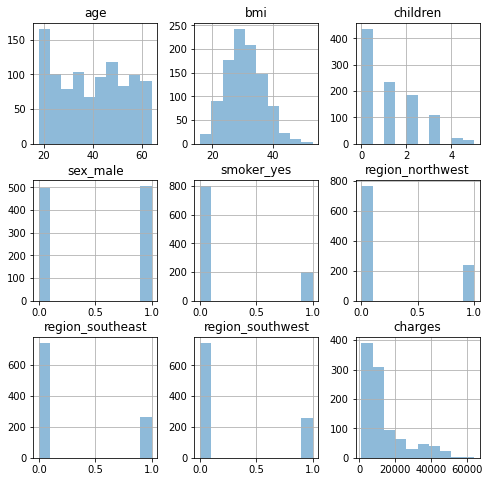

In [30]:
# 2.7 Perform univariate analysis - histograms
df_train.hist(figsize=(8,8), alpha=0.5)
plt.show()


La única variable que parece tener una distribucion normal es bmi, igualmente normalizamos todas las contínuas

In [31]:
num_2=['age', 'children', 'bmi', 'charges']

In [32]:
def normalize(b, z):
    return (z-df_train[b].min())/(df_train[b].max()-df_train[b].min())

In [33]:
for i in num_2:
    df_train[f"{i}_N"] = df_train.apply(lambda x: normalize(i, x[i]), axis=1)
    df_train = df_train.drop([f"{i}"], axis=1)

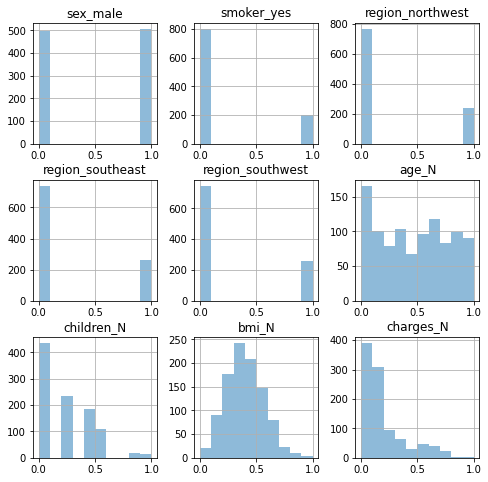

In [34]:
#chequeamos que funcionó normalización

df_train.hist(figsize=(8,8), alpha=0.5)
plt.show()

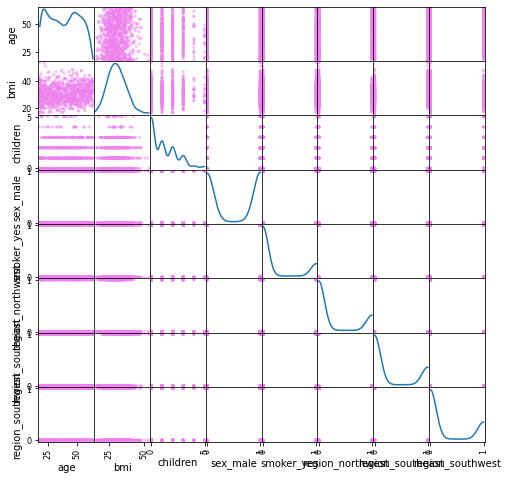

In [35]:
# 2.9 Perform bivariate analysis - numericals
pd.plotting.scatter_matrix(X_train, diagonal="kde", figsize=(8,8), c='Violet')
plt.show()

In [36]:
# 2.10 Perform correlation analysis - Pearson or Point Biserial
X_train.corr().style.background_gradient(cmap='Blues')

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.107326,0.037435,-0.036953,-0.045139,0.005725,-0.032347,0.016242
bmi,0.107326,1.000000,0.010865,0.055698,0.009927,-0.118244,0.259110,-0.000027
children,0.037435,0.010865,1.000000,0.008993,0.027960,0.021897,-0.024411,0.021414
sex_male,-0.036953,0.055698,0.008993,1.000000,0.114309,-0.010785,0.041066,-0.013289
smoker_yes,-0.045139,0.009927,0.027960,0.114309,1.000000,-0.047407,0.099608,-0.047136
region_northwest,0.005725,-0.118244,0.021897,-0.010785,-0.047407,1.000000,-0.330689,-0.325578
region_southeast,-0.032347,0.259110,-0.024411,0.041066,0.099608,-0.330689,1.000000,-0.349912
region_southwest,0.016242,-0.000027,0.021414,-0.013289,-0.047136,-0.325578,-0.349912,1.000000


In [37]:


# 2.11 Perform multivariate analysis - VIF (solo para numericas VD)
#hace una autoregresion lineal entre solo VD y ve la multicolinealidad entre ellas.
vif=pd.DataFrame()
X_numeric=X_train._get_numeric_data()
X_numeric=add_constant(X_numeric) #le agregamos una columna constante dummy de 1,1,1,1 
vif['features']=X_numeric.columns
vif['vif']=[variance_inflation_factor(X_numeric.values, i ) for i in range(X_numeric.shape[1])]
vif
#variance_inflation_factor calcula
# >10 alta multicolinealidad sacamos
# 5<i<10 medio transformamos  
# <5 no hay multicolinealidad

,features,vif
0,const,35.025334
1,age,1.020183
2,bmi,1.102298
3,children,1.004042
4,sex_male,1.018091
5,smoker_yes,1.026292
6,region_northwest,1.497799
7,region_southeast,1.636248
8,region_southwest,1.533278


In [38]:
# 2.12 Analyze effect on response variable (DV)
df_train.corr().style.background_gradient(cmap='Blues')

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_N,children_N,bmi_N,charges_N
sex_male,1.000000,0.114309,-0.010785,0.041066,-0.013289,-0.036953,0.008993,0.055698,0.079140
smoker_yes,0.114309,1.000000,-0.047407,0.099608,-0.047136,-0.045139,0.027960,0.009927,0.777898
region_northwest,-0.010785,-0.047407,1.000000,-0.330689,-0.325578,0.005725,0.021897,-0.118244,-0.036320
region_southeast,0.041066,0.099608,-0.330689,1.000000,-0.349912,-0.032347,-0.024411,0.259110,0.083994
region_southwest,-0.013289,-0.047136,-0.325578,-0.349912,1.000000,0.016242,0.021414,-0.000027,-0.049578
age_N,-0.036953,-0.045139,0.005725,-0.032347,0.016242,1.000000,0.037435,0.107326,0.286861
children_N,0.008993,0.027960,0.021897,-0.024411,0.021414,0.037435,1.000000,0.010865,0.091525
bmi_N,0.055698,0.009927,-0.118244,0.259110,-0.000027,0.107326,0.010865,1.000000,0.199202
charges_N,0.079140,0.777898,-0.036320,0.083994,-0.049578,0.286861,0.091525,0.199202,1.000000


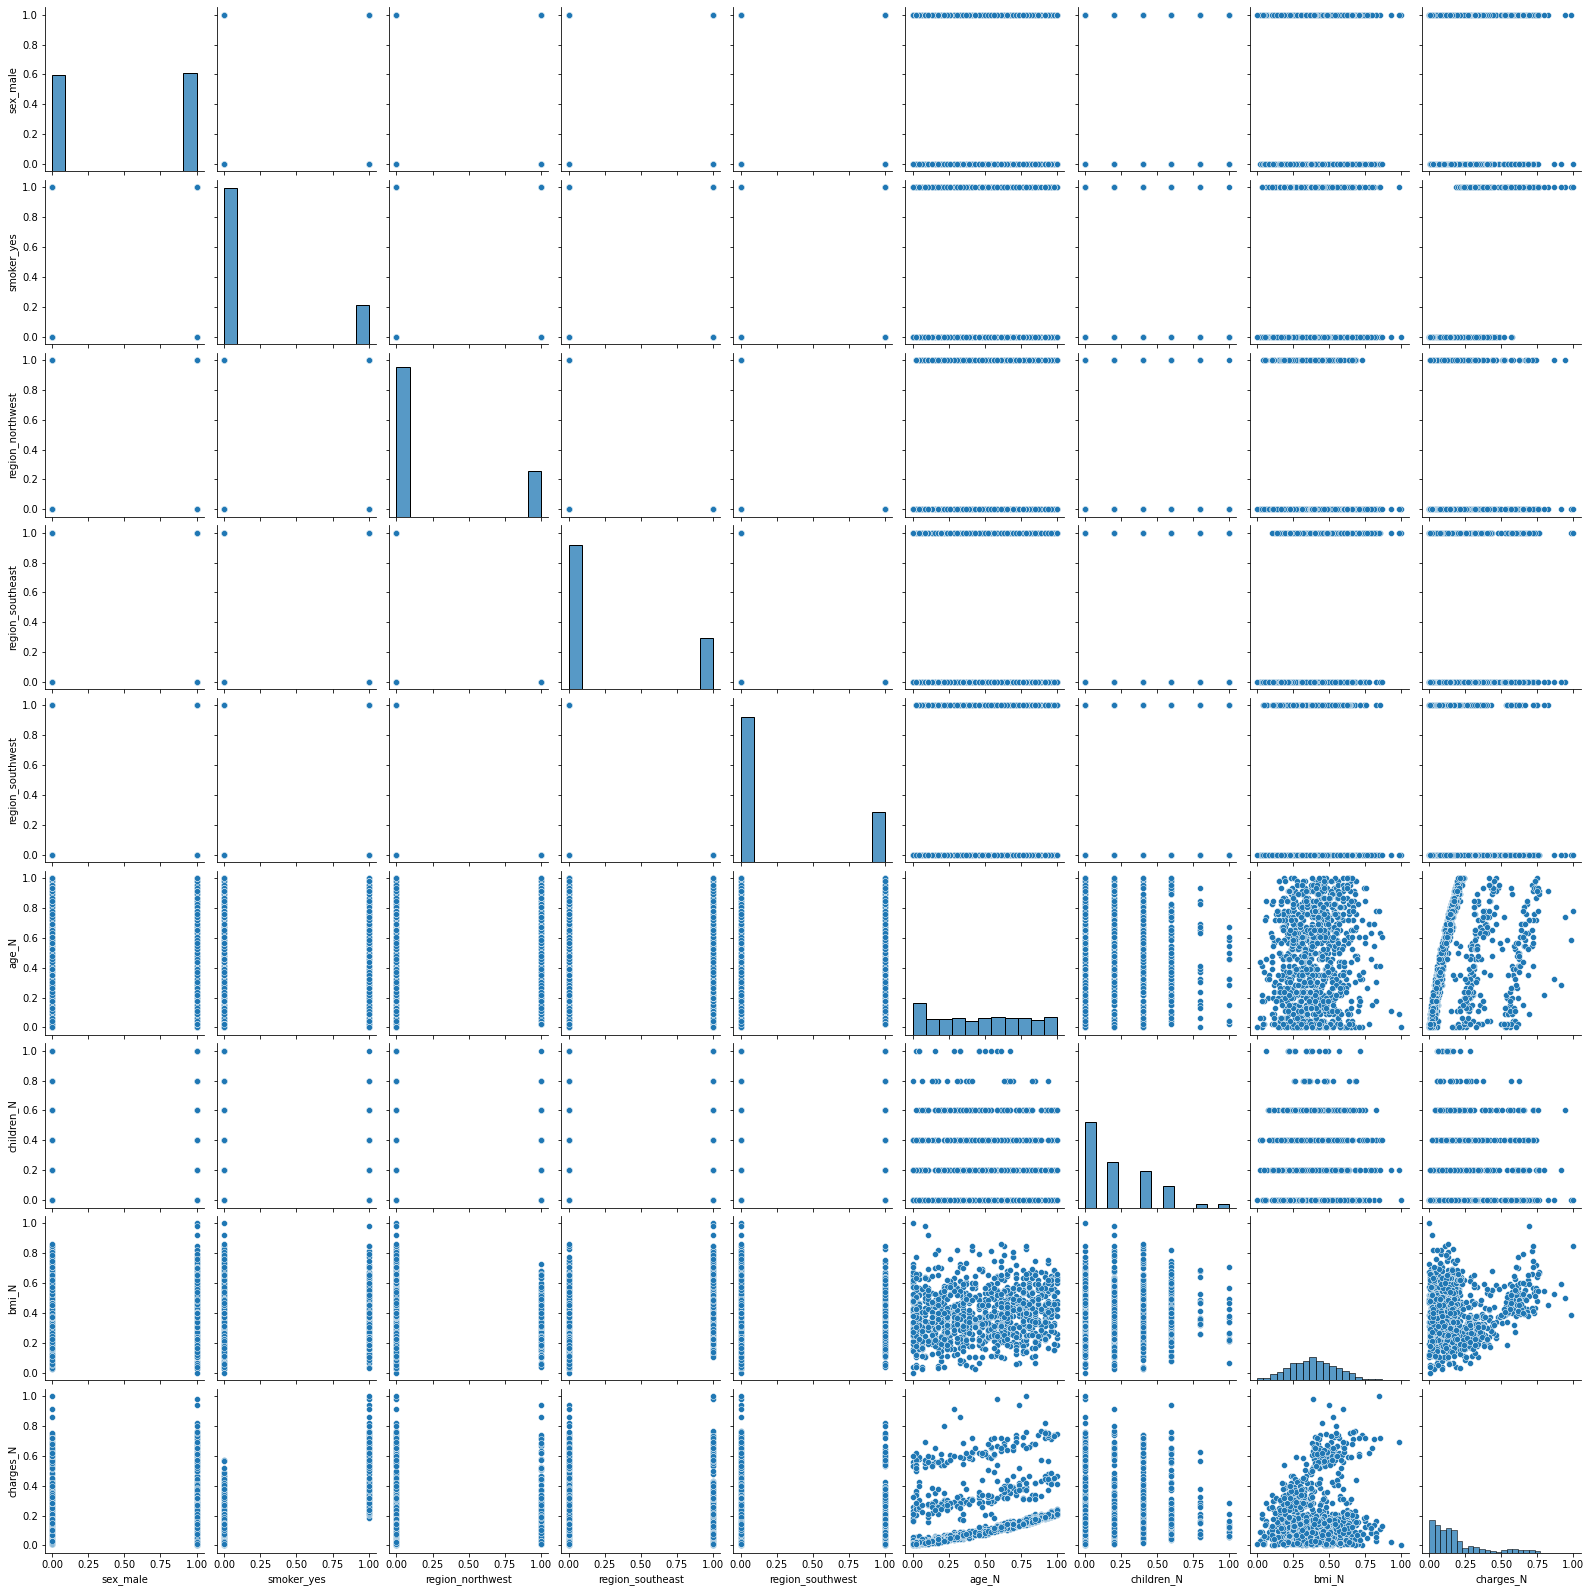

In [39]:
sns.pairplot(data=df_train)
plt.show()

In [40]:
# 2.13 Analyze of response variable (DV)

# charges según sexo
fig = px.box(df_raw, x="sex", y="charges")
fig.show()

In [41]:
# charges según region
fig = px.box(df_raw, x="region", y="charges")
fig.show()

In [42]:
# charges según fumadores
fig = px.box(df_raw, x="smoker", y="charges")
fig.show()

In [43]:
# charges según si tienen hijos
fig = px.box(df_raw, x="children", y="charges")
fig.show()

Text(0, 0.5, 'Charges')

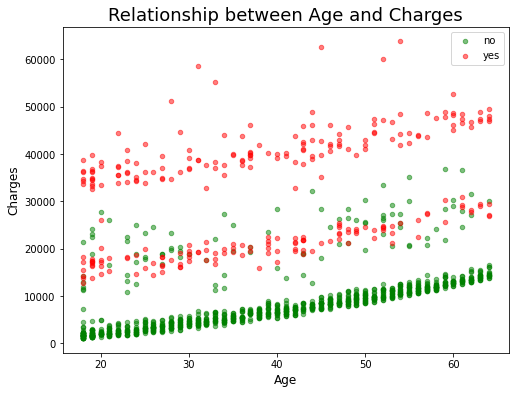

In [44]:
# scatter plot charges según edad, identificando con colores si fuma o no fuma
ax1 = df_raw[df_raw['smoker'] == 'no'].plot(kind='scatter', x='age', y='charges', color='green', alpha=0.5, figsize=(8,6))
df_raw[df_raw['smoker'] == 'yes'].plot(kind='scatter', x='age', y='charges', color='red', alpha=0.5, figsize=(8,6), ax=ax1)
plt.legend(labels=['no', 'yes'])
plt.title('Relationship between Age and Charges', size=18)
plt.xlabel('Age', size=12)
plt.ylabel('Charges', size=12)

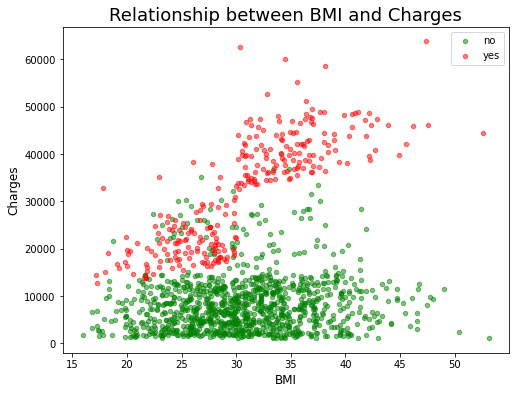

In [45]:


# scatter plot charges según BMI, identificando con colores si fuma o no fuma
ax1 = df_raw[df_raw['smoker'] == 'no'].plot(kind='scatter', x='bmi', y='charges', color='green', alpha=0.5, figsize=(8,6))
df_raw[df_raw['smoker'] == 'yes'].plot(kind='scatter', x='bmi', y='charges', color='red', alpha=0.5, figsize=(8,6), ax=ax1)
plt.legend(labels=['no', 'yes'])
plt.title('Relationship between BMI and Charges', size=18)
plt.xlabel('BMI', size=12)
plt.ylabel('Charges', size=12);

Text(0, 0.5, 'Charges')

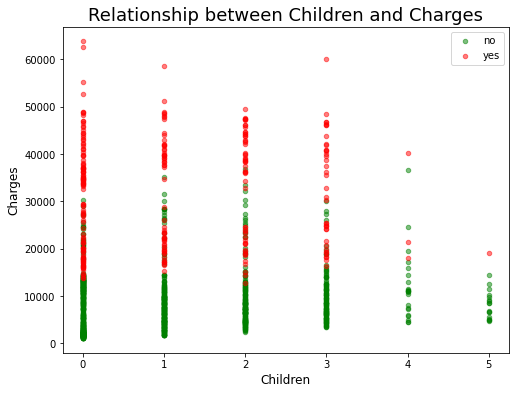

In [46]:
# scatter plot charges según children, identificando con colores si fuma o no fuma
ax1 = df_raw[df_raw['smoker'] == 'no'].plot(kind='scatter', x='children', y='charges', color='green', alpha=0.5, figsize=(8,6))
df_raw[df_raw['smoker'] == 'yes'].plot(kind='scatter', x='children', y='charges', color='red', alpha=0.5, figsize=(8,6), ax=ax1)
plt.legend(labels=['no', 'yes'])
plt.title('Relationship between Children and Charges', size=18)
plt.xlabel('Children', size=12)
plt.ylabel('Charges', size=12)

In [47]:
X_train

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
826,56,31.790,2,1,1,0,1,0
570,31,29.100,0,0,0,0,0,1
520,50,27.360,0,0,0,0,0,0
151,48,29.700,0,1,0,0,1,0
1316,19,20.600,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
1223,20,24.420,0,0,1,0,1,0
667,40,32.775,2,0,1,1,0,0
156,48,24.420,0,1,1,0,1,0
384,44,22.135,2,1,0,0,0,0


In [48]:
y_train

826     43813.86610
570      3761.29200
520     25656.57526
151      7789.63500
1316     1731.67700
           ...     
1223    26125.67477
667     40003.33225
156     21223.67580
384      8302.53565
645     10141.13620
Name: charges, Length: 1003, dtype: float64

In [49]:
# Step 3. Create and evaluate model - Define your approach and goals
#Model1: LinearRegression
model1 = LinearRegression()

# fit linear regression to train data
model1.fit(X_train, y_train)

print('Intercept:',model1.intercept_)
print('Variables:', X_train.columns)
print('Slope:', model1.coef_)
score=model1.score(X_train, y_train)
print(f'model1 R2-score (train) es {score: .4f} (proporcion de varianza de VD explicada por las VI)')

Intercept: -11812.952212787559
Variables: Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')
Slope: [  259.28377294   334.33013348   560.38480047  -216.92164981
 24043.57115706  -210.36710762 -1159.01410243  -989.16702841]
model1 R2-score (train) es  0.7387 (proporcion de varianza de VD explicada por las VI)


In [50]:
# Another option to fit a linear regression (statsmodels)
model1_B=smf.ols('charges_N ~ bmi_N + sex_male + smoker_yes + region_northwest + region_southeast + region_southwest + age_N + children_N', data=df_train).fit()
print(model1_B.summary())

                            OLS Regression Results                            
Dep. Variable:              charges_N   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     351.2
Date:                Sat, 20 Aug 2022   Prob (F-statistic):          1.85e-283
Time:                        16:36:47   Log-Likelihood:                 895.89
No. Observations:                1003   AIC:                            -1774.
Df Residuals:                     994   BIC:                            -1730.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0468      0.011  

In [51]:
#prediccion
y_pred1=model1.predict(X_test)
print(f'model1 The R2-score (test) es:{r2_score(y_test, y_pred1)}')
print('model1 MAE - regression with intercept', metrics.mean_absolute_error(y_test, y_pred1))
print('model1 MSE - regression with intercept', metrics.mean_squared_error(y_test, y_pred1))
print(f'model1 The RSME es: {mean_squared_error(y_test, y_pred1, squared=False)}')

model1 The R2-score (test) es:0.7866857073627448
model1 MAE - regression with intercept 4023.6471495940405
model1 MSE - regression with intercept 30723136.826880053
model1 The RSME es: 5542.845553222645


In [52]:
#Model2: LinearRegression without intercept
model2 = LinearRegression(fit_intercept=False)
# fit linear regression
model2.fit(X_train, y_train)

# predict
y_pred2 = model2.predict(X_test)

print('Intercept:',model2.intercept_)
print('Variables:', X_train.columns)
print('Slope:', model2.coef_)
score=model2.score(X_train, y_train)
print(f'model2 R2-score (train) es {score: .4f} (proporcion de varianza de VD explicada por las VI)')

# Performance metrics
print(f'model2 The R2-score (test) es:{r2_score(y_test, y_pred2)}')
print('model2 MAE - regression without intercept', metrics.mean_absolute_error(y_test, y_pred2))
print('model2 MSE - regression without intercept', metrics.mean_squared_error(y_test, y_pred2))
print('model2 RMSE - regression without intercept', metrics.mean_squared_error(y_test, y_pred2,squared=False))

Intercept: 0.0
Variables: Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')
Slope: [  204.58595225    69.21025209   371.7742913   -742.35489543
 23579.74455128 -1506.04330995 -1399.77505837 -1925.52747762]
model2 R2-score (train) es  0.7116 (proporcion de varianza de VD explicada por las VI)
model2 The R2-score (test) es:0.757893105882032
model2 MAE - regression without intercept 4278.042622074816
model2 MSE - regression without intercept 34870064.92980866
model2 RMSE - regression without intercept 5905.088054365376


In [53]:
#Hyperparameters tuning
# Grid search and cross validation

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))
param_grid = {'polynomialfeatures__degree': np.arange(4), # polynomial (0,1,2,3)
              'linearregression__fit_intercept': [True, False], # with and without intercept
              'linearregression__normalize': [True, False]} # normalize and not normalize

grid = GridSearchCV(PolynomialRegression(), param_grid) # 5 folds

grid.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)



/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Standar

GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'linearregression__normalize': [True, False],
                         'polynomialfeatures__degree': array([0, 1, 2, 3])})

In [54]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 2}

In [55]:
model3 = grid.best_estimator_

#prediction
y_pred3 = model3.fit(X_train, y_train).predict(X_test)

# Performance metrics
print(f'model3 The R2-score (test) es:{r2_score(y_test, y_pred3)}')
print('model3 MAE - regression without intercept', metrics.mean_absolute_error(y_test, y_pred3))
print('model3 MSE - regression without intercept', metrics.mean_squared_error(y_test, y_pred3))
print('model3 RMSE - regression without intercept', metrics.mean_squared_error(y_test, y_pred3,squared=False))

model3 The R2-score (test) es:0.8749904658767071
model3 MAE - regression without intercept 2762.1262584781043
model3 MSE - regression without intercept 18004818.027199004
model3 RMSE - regression without intercept 4243.208459078932


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)





In [56]:
#save model to disk
filename='../models/final_model.sav'
pickle.dump(model3, open(filename, 'wb'))